In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04-2c_Projects_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Project_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 54118/54118 [14:15<00:00, 63.28it/s]


## Centroids

In [6]:
authors_centroids = {}

for group in test_data.groupby('project'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [8]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000,0.310,0.315,0.268,0.295,0.296,0.371,0.308,0.299,0.304,0.332,0.314,0.324,0.268,0.311
1,0.000,0.000,0.195,0.180,0.194,0.210,0.326,0.184,0.171,0.167,0.229,0.170,0.189,0.180,0.189
2,0.000,0.000,0.000,0.184,0.200,0.180,0.342,0.192,0.097,0.128,0.238,0.111,0.167,0.190,0.129
3,0.000,0.000,0.000,0.000,0.151,0.193,0.292,0.140,0.154,0.139,0.195,0.149,0.159,0.125,0.180
4,0.000,0.000,0.000,0.000,0.000,0.215,0.298,0.123,0.172,0.147,0.209,0.156,0.162,0.138,0.188
5,0.000,0.000,0.000,0.000,0.000,0.000,0.355,0.205,0.148,0.194,0.254,0.179,0.212,0.197,0.164
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.297,0.326,0.314,0.344,0.319,0.322,0.303,0.336
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.167,0.122,0.184,0.138,0.137,0.131,0.187
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.207,0.098,0.153,0.162,0.114
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.191,0.087,0.121,0.145,0.147


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

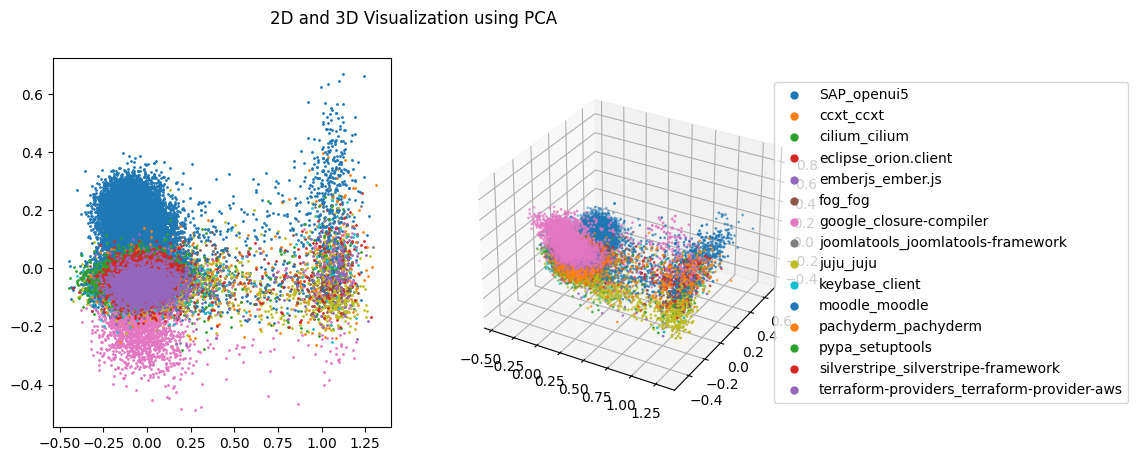

In [9]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data, projects=True)

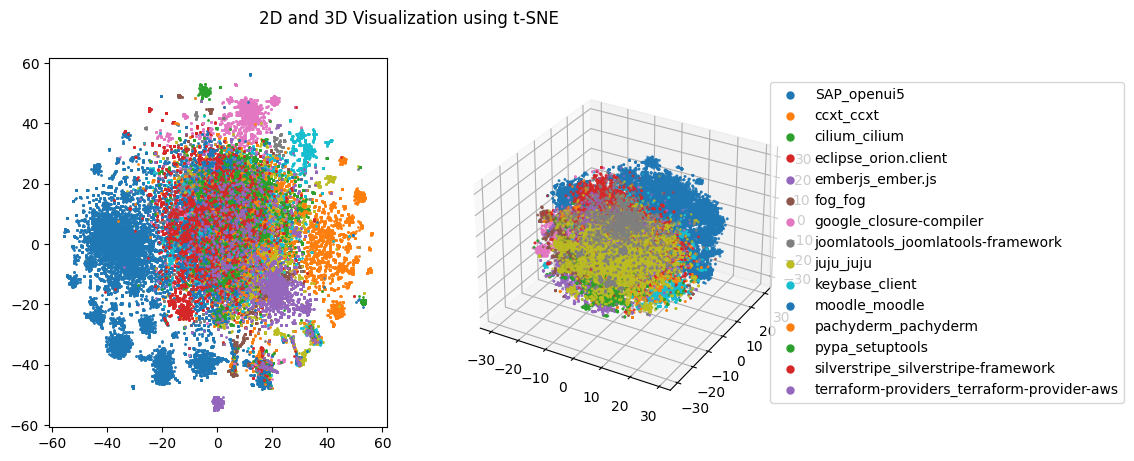

In [10]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, projects=True)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 4
10 Most common:
[(0, 51942), (-1, 2136), (1, 20), (2, 20)]


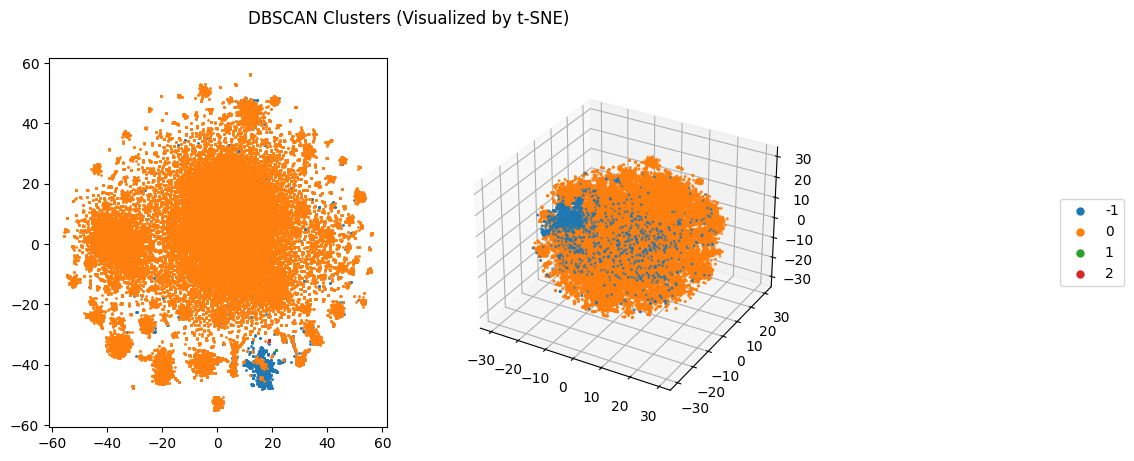

In [11]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [12]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 4321 different authors.
There are 15 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2136.0,651.0,1.0,"('igor.kroitor@gmail.com', 156)",15.0,93.0,"('moodle_moodle', 595)"
1,51942.0,4225.0,1.0,"('igor.kroitor@gmail.com', 2726)",15.0,2170.0,"('moodle_moodle', 16158)"
2,20.0,1.0,20.0,"('igor.kroitor@gmail.com', 20)",1.0,20.0,"('ccxt_ccxt', 20)"
3,20.0,7.0,1.0,"('igor.kroitor@gmail.com', 13)",2.0,10.0,"('ccxt_ccxt', 19)"


In [13]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,4.000000,4.000000,4.00,4.000000,4.000000
mean,13529.500000,1221.000000,5.75,8.250000,573.250000
std,25627.753049,2025.760104,9.50,7.804913,1065.142674
min,20.000000,1.000000,1.00,1.000000,10.000000
25%,20.000000,5.500000,1.00,1.750000,17.500000
50%,1078.000000,329.000000,1.00,8.500000,56.500000
75%,14587.500000,1544.500000,5.75,15.000000,612.250000
max,51942.000000,4225.000000,20.00,15.000000,2170.000000


In [14]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3
length_mean,91.753745,89.636267,32.000000,46.800000
length_std,74.573257,72.079660,7.355270,13.249906
n_uppercase_mean,6.629213,5.834508,0.400000,1.900000
n_uppercase_std,7.630339,6.610886,0.916515,2.406242
polarity_mean,0.020135,0.010809,0.020000,0.033333
polarity_std,0.177076,0.165539,0.114455,0.184917
subjectivity_mean,0.194172,0.186234,0.075000,0.150000
subjectivity_std,0.275145,0.269442,0.129904,0.241997


In [15]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
[INTERNAL] sap.m.DateTimeInput: Islamic calendar is not supported.

Change-Id: Ifa<I>c<I>b3ee<I>b<I>e<I>c7a<I>c<I>b4
___
2) 
[FIX] sap.m.Dialog: delayed set of height and width now works

Change-Id: I<I>bb<I>e0bb0d0aeec<I>d4c0f<I>d4a5
BCP: <I>
___
3) 
[INTERNAL] ResourceBundle: allow log-free probing for texts

When the caller of getText() is obviously prepared to get no text, then
do not complain via assert when the text is indeed missing. This avoids
polluting the log in scenarios, where a kind of text-probing is done.

Change-Id: I<I>fe<I>a<I>fe<I>f4a3df<I>f<I>ea<I>f2cf<I>
___
4) 
[FIX] v2.ODataListBinding: isReloadNeeded not parameterized correctly

When using isRelaodNeeded to check whether entities contained in the
list are complete, the select and expand parameters were not passed, so
if the list was using select/expand it was automatically switched to
server mode after every request.

Change-Id: I9bc<I>aaffbdf5b<I>ff<I>dcdd7f5

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 15
10 Most common:
[(14, 10938), (4, 9421), (6, 8466), (0, 8350), (9, 6657), (2, 2420), (13, 1734), (12, 1289), (10, 1179), (1, 1123)]


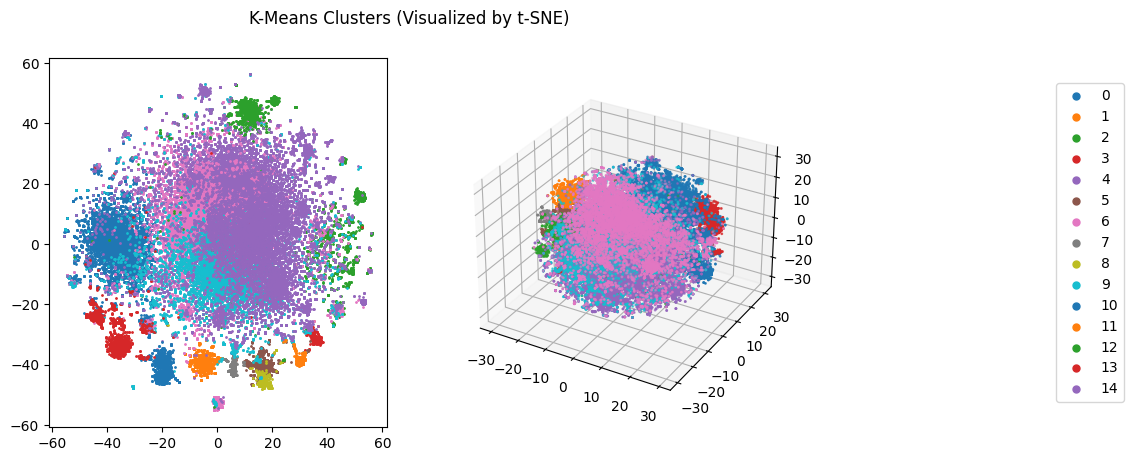

In [16]:
kmeans = KMeans(15)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [17]:
silhouette_score(vectors, kmeans_prediction)

0.03420474

In [18]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 4321 different authors.
There are 15 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,8350.0,519.0,2.0,"('skodak', 464)",9.0,4.0,"('moodle_moodle', 8319)"
1,1123.0,174.0,4.0,"('teodor.taushanov@sap.com', 54)",2.0,561.5,"('SAP_openui5', 1116)"
2,2420.0,290.0,1.0,"('igor.kroitor@gmail.com', 1310)",14.0,7.5,"('ccxt_ccxt', 2294)"
3,403.0,158.0,1.0,"('tycho.andersen@canonical.com', 22)",14.0,12.5,"('juju_juju', 204)"
4,9421.0,1376.0,1.0,"('jaraco@jaraco.com', 507)",15.0,528.0,"('juju_juju', 1340)"
5,1080.0,440.0,1.0,"('igor.kroitor@gmail.com', 86)",15.0,73.0,"('ccxt_ccxt', 149)"
6,8466.0,1433.0,1.0,"('igor.kroitor@gmail.com', 473)",15.0,489.0,"('moodle_moodle', 1589)"
7,339.0,155.0,1.0,"('nick-github@snowmonkey.co.uk', 28)",11.0,8.0,"('fog_fog', 186)"
8,383.0,160.0,1.0,"('igor.kroitor@gmail.com', 35)",13.0,6.0,"('moodle_moodle', 275)"
9,6657.0,1472.0,1.0,"('moodler', 418)",15.0,363.0,"('moodle_moodle', 1504)"


In [19]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,3607.866667,565.133333,1.400000,10.533333,258.833333
std,3907.273654,578.216206,0.828079,5.235411,355.488932
min,336.000000,98.000000,1.000000,1.000000,1.000000
25%,741.500000,159.000000,1.000000,7.000000,5.500000
50%,1289.000000,249.000000,1.000000,13.000000,12.500000
75%,7503.500000,947.500000,1.500000,15.000000,508.500000
max,10938.000000,1601.000000,4.000000,15.000000,1179.000000


In [20]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
length_mean,89.000719,193.579697,51.213636,91.397022,86.223543,101.779630,92.811481,111.787611,94.801567,81.572931,87.525869,82.997024,100.280062,99.255479,89.090419
length_std,67.061930,73.475044,39.307132,85.650865,70.622227,76.986059,72.109958,87.998034,72.038881,69.501475,49.259555,82.886953,44.340682,67.416341,76.958360
n_uppercase_mean,6.697126,23.451469,2.837190,3.868486,4.837278,7.384259,6.004607,7.563422,6.530026,4.350458,13.765055,3.196429,12.707525,5.673010,4.082282
n_uppercase_std,4.163759,6.790341,3.849861,5.044229,5.843095,8.467997,7.115686,9.994303,5.375072,6.056905,6.407158,4.429015,7.101871,4.821353,5.235485
polarity_mean,0.007610,0.004817,-0.005958,0.005565,0.010370,0.011726,0.011914,0.002912,-0.000487,0.025768,0.016537,0.000853,-0.004550,0.021539,0.010411
polarity_std,0.175763,0.115461,0.126652,0.190817,0.176550,0.156055,0.165179,0.139157,0.171884,0.150017,0.175931,0.155548,0.156941,0.163309,0.171272
subjectivity_mean,0.202034,0.168245,0.101236,0.196251,0.194950,0.178565,0.198877,0.163761,0.194756,0.179828,0.188714,0.142575,0.147184,0.207923,0.185732
subjectivity_std,0.263830,0.229843,0.217583,0.277212,0.275475,0.252853,0.274186,0.249557,0.275954,0.277395,0.254028,0.238966,0.266010,0.265473,0.275607


In [21]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
[INTERNAL] mdc: added Link to library

Change-Id: Ic<I>e<I>f2ed<I>c3b<I>d<I>f<I>c8
___
2) 
[INTERNAL] MDC Chart Remake: added hidden aggregations

Change-Id: I<I>c9d<I>eee<I>d<I>f8e2bed<I>d<I>af
___
3) 
[INTERNAL][FIX] MDC Chart Remake: Fixed issue when item is not present in property infos

Change-Id: I<I>f<I>cead<I>b<I>e3f0ed<I>aab<I>da
___
4) 
[INTERNAL][FIX] MDC Chart Remake: Fixed control delegate being accesed before it was initialized

Change-Id: I<I>e<I>e9bc5a<I>e6b<I>e<I>bb<I>db1c<I>c
___
5) 
edited setup.py [skip ci]
___
6) 
add while (xxx) language syntax support
___
7) 
use projection model to properly map MD editor selection co-ordinates
___
8) 
use projection model to properly map MD editor selection co-ordinates (pt. 2)
___
9) 
Add missing required(boolean) method to $mdDialog PromptConfig

-------------
Created by MOE: <URL>
___
10) 
Add $mdAriaProvider.disableWarnings to the Angular Material <I> externs.

------------